**Task** = Build recommender system / LTR system based on user activity logs

**Choice** = Top-k recommender system based on collaborative filtering


**Reason** = Fast to prototype, typically gets 'decent' first pass results

In [1]:
#using lightfm to build a recommender system based on collaborative filtering
!pip install lightfm

     |████████████████████████████████| 307kB 3.4MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707614 sha256=0b824873d8262da0855657a05587355ecd503dc994c5e433bb299c91bf72ee4d
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [0]:
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import auc_score
from lightfm.evaluation import reciprocal_rank
from lightfm.cross_validation import random_train_test_split

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**STEP1: Load and pre-process data**

In [3]:
# read input dataset
df = pd.read_csv("takehome_data.tsv", sep='\t')
df.drop_duplicates(keep='first', inplace=True)
print(f'raw data = {df.shape}')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (30,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


raw data = (177588, 49)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177588 entries, 0 to 177587
Data columns (total 49 columns):
id_search                          177588 non-null object
label                              177588 non-null object
id_user                            177588 non-null object
id_listing                         177588 non-null object
ts_search                          177588 non-null object
ds_search                          177588 non-null object
ds_book                            2240 non-null object
ds_contact                         5273 non-null object
query_market                       177588 non-null object
query_checkin                      177588 non-null object
query_checkout                     177588 non-null object
query_num_guests                   177588 non-null int64
query_num_children                 177588 non-null int64
query_num_infants                  177588 non-null int64
query_radius                       177588 non-null float64
query_price_max          

In [0]:
# get all listing and query features that have 'good' & 'full' data
listing_features_list = [k for k,v in dict(df.isnull().sum()).items() \
                         if k.startswith('listing') and is_numeric_dtype(df[k]) and v==0]
query_features_list = [k for k,v in dict(df.isnull().sum()).items() \
                       if k.startswith('query') and is_numeric_dtype(df[k]) and v==0]

In [0]:
# remove some of the manually selected features
# either not enough data (boolean columns) or not enough variation in data
listing_features_list = set(listing_features_list) - {'listing_is_new', 
                                                      'listing_instant_bookable', 
                                                      'listing_lat', 
                                                      'listing_lng', 
                                                      'listing_monthly_discount',
                                                      'listing_weekly_discount', 
                                                      'listing_num_recent_reservations'}
query_features_list = set(query_features_list) - {'query_center_lat', 
                                                  'query_center_lng', 
                                                  'query_num_infants', 
                                                  'query_num_children'}

Convert data columns into category columns

In [0]:
# features specific to items (listings)
for col in listing_features_list:
  df[col+'_quant_cat'] = pd.qcut(df[col].astype(float).values, 5, duplicates='drop').codes + 1
listing_cat_features_list = [col+'_quant_cat' for col in listing_features_list]

In [0]:
# features specific to users (given at query level)
query_features_list = list(query_features_list)
df['query_num_guests'].clip(lower=0, inplace=True) # doesn't make sense to be -ve
user_df = df[query_features_list+['id_user']].groupby('id_user')[query_features_list].mean()
for col in query_features_list:
  df[col] = df['id_user'].map(user_df[col])
for col in query_features_list:
  df[col+'_quant_cat'] = pd.qcut(df[col].astype(float).values, 5, duplicates='drop').codes + 1
query_cat_features_list = [col+'_quant_cat' for col in query_features_list]

**STEP2: Exploratory Data Analysis (listings and queries)**

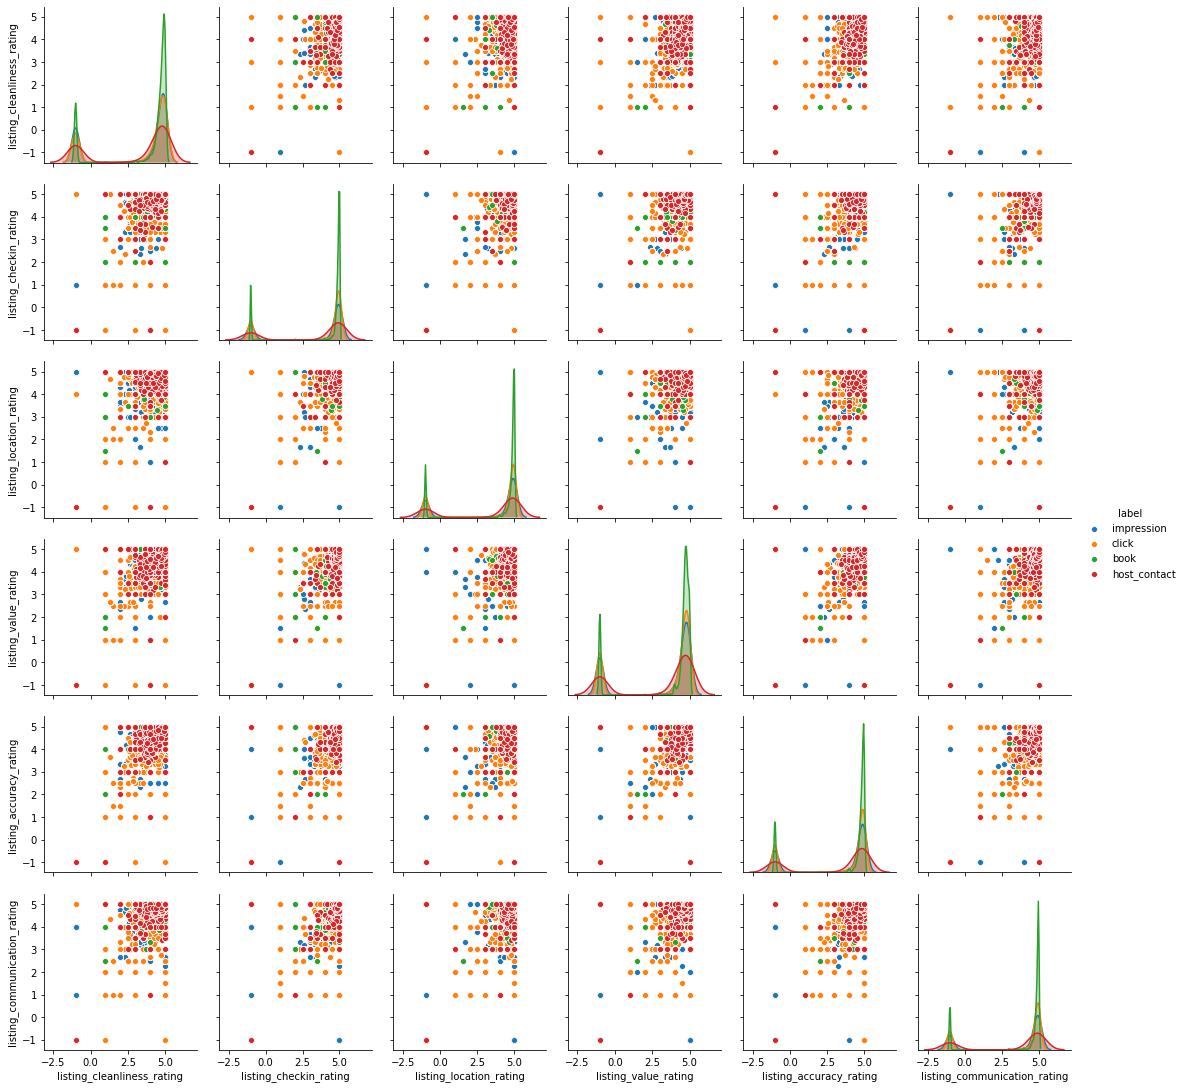

In [9]:
# check how raw data looks like
# mostly only ratings close to 5 star seem to get booked (obviously)
# if not, users tend to try new listings
sns.pairplot(df[[col for col in listing_features_list if 'rating' in col]+['label']], hue="label", diag_kind="kde")

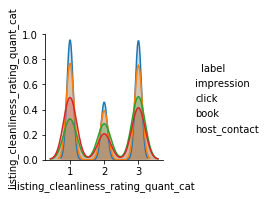

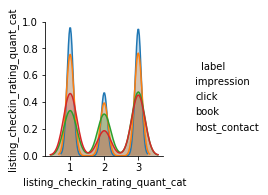

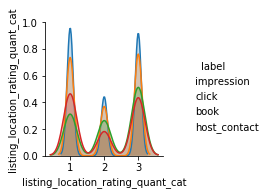

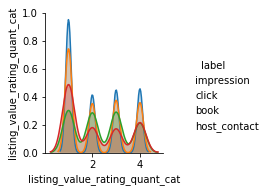

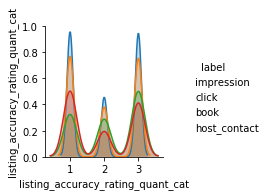

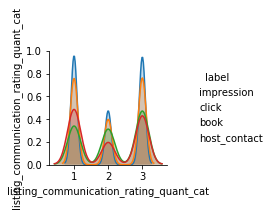

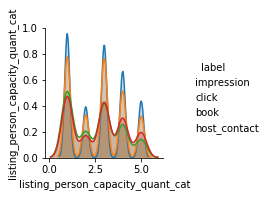

In [10]:
# check how our encoding of these features/columns looks like
# mostly ratings can be categorized into just 3 groups
for col in listing_cat_features_list:
  sns.pairplot(df[[col]+['label']], hue="label", diag_kind="kde")

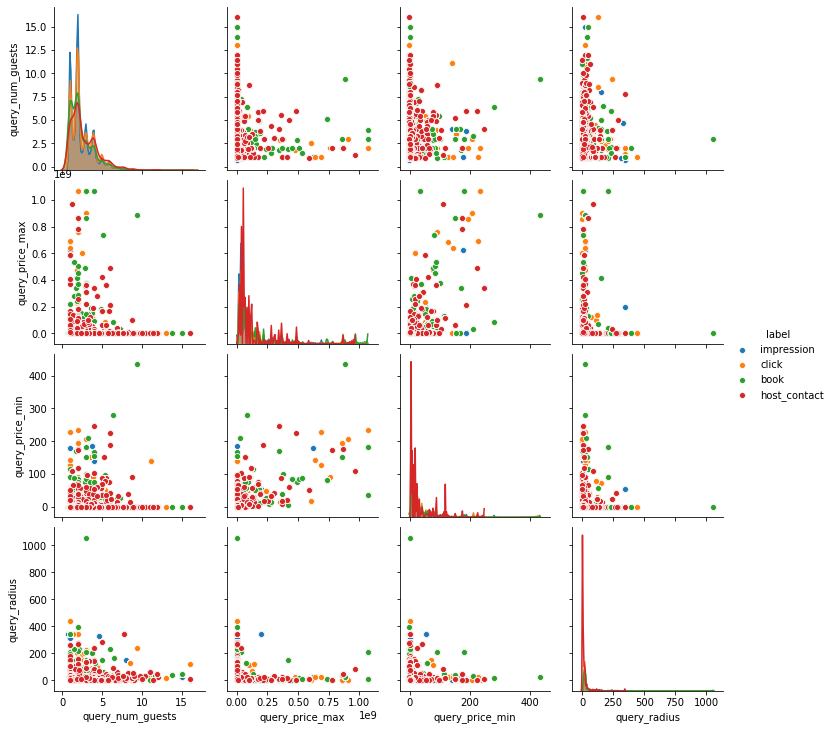

In [11]:
# check how raw data looks like -> mostly all queries that result in booking have features such as:
# 1. Search radius for booking is very narrow
# 2. Not a lot of people look for listings that support kids/infants
# 3. Search for accomodations with low number of guests seems to be popular
sns.pairplot(df[[col for col in query_features_list]+['label']], hue="label", diag_kind="kde")

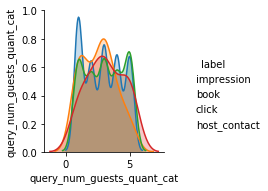

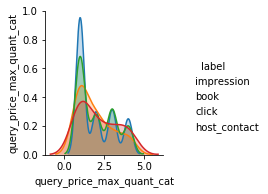

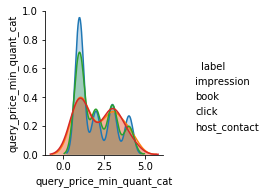

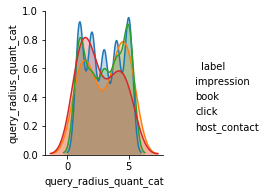

In [12]:
# check how our encoding of these features/columns looks like
# price min/max filters seem very skewed towards lower quantile
# bookings seem to be very specific to one center location
tmp = df.drop_duplicates(subset=['id_user'], keep='last')
for col in query_cat_features_list:
  sns.pairplot(tmp[[col]+['label']], hue="label", diag_kind="kde")

**STEP3: Prepare data for model**

In [0]:
def calc_scores(df, 
                alpha = 5, beta = 10, gamma = 0.01, 
                weights = {'impression': 1, 'click': 10, 'host_contact': 75, 'book': 100}):
  '''
  calculate scores to fill interaction matrix
  use event type & booking probability
  '''
  df_user_hist = df.groupby('id_user')['label'].apply(list).to_frame()
  df_listing_hist = df.groupby('id_listing')['label'].apply(list).to_frame()
  df = df.join(df_user_hist, on='id_user', rsuffix='_user_hist')
  df = df.join(df_listing_hist, on='id_listing', rsuffix='_listing_hist')
  df['user_book_prob'] = df['label_user_hist'].apply(lambda li: len([it for it in li if it=='book']) / len(li))
  df['listing_book_prob'] = df['label_listing_hist'].apply(lambda li: len([it for it in li if it=='book']) / len(li))
  df['interaction_weight'] = df['label'].map(weights)
  df['book_prob'] = (df['user_book_prob'] * alpha + 
                    df['listing_book_prob'] * beta + 
                    df['user_book_prob'] * df['listing_book_prob'] +
                    gamma) * df['interaction_weight']
  return df

In [0]:
df = calc_scores(df)

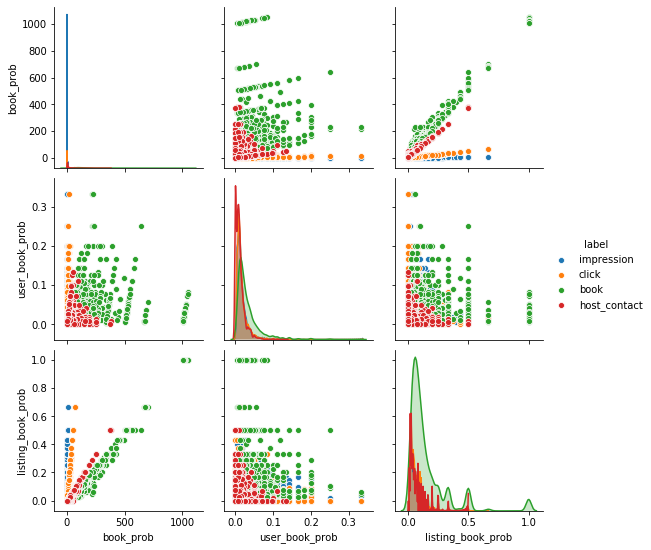

In [15]:
# verify how our scoring function is behaving
# objective is to have bookings a higher book_prob, impressions to have lower 
# clearly a lot of searches are made, but comparitively very few bookings
# also, there seem to be SUPER users & listings
sns.pairplot(df[['book_prob', 'user_book_prob', 'listing_book_prob', 'label']], hue="label", diag_kind="kde")

Try a couple of data splitting ideas

In [0]:
def split_based_on_last_search(df):
  '''
  split data into train / test based on time 
  (final searches are test, all history before final search is train)
  LESSON = Bookings by users are typically not for the same place again & again
  '''
  final_search = df.groupby('id_user')['ts_search'].apply(max).to_frame()
  df = df.join(final_search, on='id_user', rsuffix='_final')
  test_df = df[df['ts_search'] == df['ts_search_final']] 
  train_df = df[~df.index.isin(test_df.index)]
  train_data = train_df[['cat_idx_user', 'cat_idx_listing', 'book_prob', 'label']]
  test_data = test_df[['cat_idx_user', 'cat_idx_listing', 'book_prob', 'label']]
  return train_data, test_data

In [0]:
def random_split(df): 
  '''
  randomly select searches from each event type
  '''
  impression = df[df['label']=='impression'].sample(frac = 0.2)
  click = df[df['label']=='click'].sample(frac = 0.2)
  host_contact = df[df['label']=='host_contact'].sample(frac = 0.2)
  book = df[df['label']=='book'].sample(frac = 0.2)
  test_df = pd.concat([impression, click, host_contact, book])
  train_df = df[~df.index.isin(test_df.index)]
  train_data = train_df[['cat_idx_user', 'cat_idx_listing', 'book_prob', 'label']]
  test_data = test_df[['cat_idx_user', 'cat_idx_listing', 'book_prob', 'label']]
  return train_data, test_data 

In [0]:
def get_user_item_matrix(df, random=True):
  '''
  create user-item matrix for both train and test data
  '''
  # map each listing and user to a unique numeric value
  df['idx_user'] = df['id_user'].astype("category")
  df['idx_listing'] = df['id_listing'].astype("category")
  df['cat_idx_user'] = df['idx_user'].cat.codes
  df['cat_idx_listing'] = df['idx_listing'].cat.codes
  df['ts_search'] =  pd.to_datetime(df['ts_search'], infer_datetime_format=True)

  # get train/test data
  if random:
    train_data, test_data = random_split(df)
  else:
    train_data, test_data = split_based_on_last_search(df)

  # group data to form user/item matrix (avoid cold start)
  grouped_train_data = train_data.groupby(['cat_idx_user', 'cat_idx_listing']).sum().reset_index()
  grouped_test_data = test_data.groupby(['cat_idx_user', 'cat_idx_listing']).sum().reset_index()

  # make sure number of items and users are same in train & test
  all_users = np.intersect1d(grouped_train_data['cat_idx_user'], grouped_test_data['cat_idx_user'])
  all_items = np.intersect1d(grouped_train_data['cat_idx_listing'], grouped_test_data['cat_idx_listing'])
  filter1 = grouped_test_data['cat_idx_user'].isin(all_users)
  filter2 = grouped_test_data['cat_idx_listing'].isin(all_items)
  grouped_test_data = grouped_test_data[filter1 & filter2]
  filter1 = grouped_train_data['cat_idx_user'].isin(all_users)
  filter2 = grouped_train_data['cat_idx_listing'].isin(all_items)
  grouped_train_data = grouped_train_data[filter1 & filter2]
  print(f'train records = {grouped_train_data.shape}, test records = {grouped_test_data.shape}')

  # create a sparse matrix of all the listing/user/count triples
  train_user_listing = csr_matrix((grouped_train_data['book_prob'].astype(float), 
                                    (grouped_train_data['cat_idx_user'], 
                                    grouped_train_data['cat_idx_listing'])))
  test_user_listing = csr_matrix((grouped_test_data['book_prob'].astype(float), 
                                    (grouped_test_data['cat_idx_user'], 
                                    grouped_test_data['cat_idx_listing'])))
  print(f'train shape = {train_user_listing.shape}, test shape = {test_user_listing.shape}')
  print(f'train sparsity = {train_user_listing.getnnz() / \
                            (train_user_listing.shape[0] * train_user_listing.shape[1])}, \
          test sparsity = {test_user_listing.getnnz() / \
                            (test_user_listing.shape[0] * test_user_listing.shape[1])}')
  
  # clean up memory before leaving
  del train_data
  del test_data
  
  return df, train_user_listing, test_user_listing, grouped_train_data, grouped_test_data

**STEP4: Train & Evaluate model**

Better to use reciprocal rank (or ndcg) than the typical precision/recall metrics

In [0]:
def model_train(matrix, item_features=None, user_features=None, 
                iters=5, seed=7, test_percentage=0.2, 
                no_components=50, learning_rate=0.05, loss='warp', item_alpha=0, user_alpha=0):
  model = LightFM(no_components=no_components, learning_rate=learning_rate, max_sampled = 100,
                  loss=loss, item_alpha=item_alpha, user_alpha=user_alpha)
  for _ in range(iters):
    (train_sample, test_sample) = random_train_test_split(matrix, test_percentage=0.2, 
                                                          random_state = np.random.RandomState(seed))
    if (item_features!=None) and (user_features!=None):
      model.fit_partial(train_sample, user_features=user_features, 
                        item_features=item_features, epochs=5, verbose=True)
      model_eval(model, train_sample, test_sample, 
                 user_features=user_features, item_features=item_features)
    else:
      model.fit_partial(train_sample, epochs=5, verbose=True)
      model_eval(model, train_sample, test_sample)      
  return model

In [0]:
def model_eval(model, train_matrix, test_matrix, item_features=None, user_features=None, k=20):
  '''
  calculate metrics for both train and test using pre-built model
  '''
  # evaluate model on train
  train_precision = precision_at_k(model, train_matrix, k=k, 
                                   user_features=user_features, item_features=item_features).mean()
  train_recall = recall_at_k(model, train_matrix, k=k, 
                             user_features=user_features, item_features=item_features).mean()
  train_reciprocal = reciprocal_rank(model, train_matrix, 
                                     user_features=user_features, item_features=item_features).mean()
  train_auc = auc_score(model, train_matrix, 
                        user_features=user_features, item_features=item_features).mean()
  print(f'Train == precision: {train_precision}, recall: {train_recall}, AUC: {train_auc}, reciprocal rank: {train_reciprocal}')

  # evaluate model on test
  test_precision = precision_at_k(model, test_matrix, train_interactions=train_matrix, k=k, 
                                  user_features=user_features, item_features=item_features, check_intersections=False).mean()
  test_recall = recall_at_k(model, test_matrix, train_interactions=train_matrix, k=k, 
                            user_features=user_features, item_features=item_features, check_intersections=False).mean()
  test_reciprocal = reciprocal_rank(model, test_matrix, train_interactions=train_matrix, 
                                    user_features=user_features, item_features=item_features, check_intersections=False).mean()
  test_auc = auc_score(model, test_matrix, train_interactions=train_matrix, 
                       user_features=user_features, item_features=item_features, check_intersections=False).mean()
  print(f'Test == precision: {test_precision}, recall: {test_recall}, AUC: {test_auc}, reciprocal rank: {test_reciprocal}')

  return

In [21]:
# train model (use cross validation) -> random split
df, train_user_listing, test_user_listing, grouped_train_data, grouped_test_data = get_user_item_matrix(df)
model = model_train(train_user_listing)
model_eval(model, train_user_listing, test_user_listing)

train records = (106804, 3), test records = (32886, 3)
train shape = (2999, 30960), test shape = (2999, 30960)
train sparsity = 0.0011502972997889907,           test sparsity = 0.00035418783005187777
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.19214236736297607, recall: 0.1563873452745611, AUC: 0.9864859580993652, reciprocal rank: 0.4717028737068176
Test == precision: 0.018139367923140526, recall: 0.05202804721652806, AUC: 0.9371969103813171, reciprocal rank: 0.08118364959955215
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.4245529770851135, recall: 0.37880547557370736, AUC: 0.9972756505012512, reciprocal rank: 0.7289839386940002
Test == precision: 0.019324714317917824, recall: 0.056508325702598894, AUC: 0.9403167963027954, reciprocal rank: 0.08339627832174301
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.5481946468353271, recall: 0.5078587036516109, AUC: 0.9989014267921448, reciprocal rank: 0.8241850733757019
Test == precision: 0.01853

In [24]:
# train model (use cross validation) -> time based split
df, train_user_listing, test_user_listing, grouped_train_data, grouped_test_data = get_user_item_matrix(df, False)
time_model = model_train(train_user_listing)
model_eval(time_model, train_user_listing, test_user_listing)

train records = (101122, 3), test records = (26141, 3)
train shape = (2998, 30960), test shape = (2998, 30960)
train sparsity = 0.001089464466405683,           test sparsity = 0.0002816369396996792
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.1761055588722229, recall: 0.1559286960745182, AUC: 0.9864468574523926, reciprocal rank: 0.4280471205711365
Test == precision: 0.018275076523423195, recall: 0.05082551492655947, AUC: 0.9463536143302917, reciprocal rank: 0.0788959413766861
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.3721112310886383, recall: 0.36496066992198384, AUC: 0.996965229511261, reciprocal rank: 0.6804327368736267
Test == precision: 0.02042173221707344, recall: 0.05901069325797095, AUC: 0.9498664736747742, reciprocal rank: 0.08501328527927399
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.49254634976387024, recall: 0.4998386279686022, AUC: 0.9987266063690186, reciprocal rank: 0.7936612963676453
Test == precision: 0.01990881562

Generate recoms from trained model & compare with ground truth

In [0]:
def get_recom_scores(model, user_idx, item_idx, item_features=None, user_features=None, k=20):
  '''
  generate top k recoms
  '''
  scores = model.predict(user_idx, item_idx,
                        item_features=item_features, 
                        user_features=user_features)
  return scores

In [0]:
def get_recoms(model, grouped_train_data, k=20):
  scores = get_recom_scores(model, 
                            grouped_train_data['cat_idx_user'].values, 
                            grouped_train_data['cat_idx_listing'].values)
  grouped_train_data['score'] = scores
  personal_recs = grouped_train_data.groupby('cat_idx_user')['cat_idx_listing'].apply(list)
  personal_recs_scores = grouped_train_data.groupby('cat_idx_user')['score'].apply(list)
  tmp = list(zip(personal_recs.values, personal_recs_scores.values))
  final_recs = {i: recs[:k] for i, (recs, scores) in enumerate(sorted(tmp, key = lambda x:x[1], reverse=True))}
  return grouped_train_data, final_recs

In [0]:
#final_recs = get_recoms(model, grouped_train_data)
grouped_train_data, final_time_recs = get_recoms(time_model, grouped_train_data)

**STEP5: Try adding listing and query features to model**

In [0]:
def create_dataset(df, listing_features, user_features):
  '''
  create data with categorical features from query & listing
  '''
  dataset = Dataset()
  dataset.fit(
      set(df['cat_idx_user']), 
      set(df['cat_idx_listing']),
      item_features=listing_features.apply(pd.Series).stack().reset_index(drop=True), 
      user_features=user_features.apply(pd.Series).stack().reset_index(drop=True))
  interactions, weights = dataset.build_interactions(list(zip(df['cat_idx_user'], df['cat_idx_listing'], df['book_prob'])))
  listing_features = dataset.build_item_features(list(zip(df['cat_idx_listing'], listing_features)))
  user_features = dataset.build_user_features(list(zip(df['cat_idx_user'], user_features)))
  print(f'interactions = {interactions.shape}, listing_features = {listing_features.shape}, user_features = {user_features.shape}')
  return interactions, listing_features, user_features


In [0]:
# get raw user (represented at query level) & item (listing) features
listing_cat_features = df[listing_cat_features_list].apply(lambda x: ','.join(x.map(str)), axis=1).str.split(',')
query_cat_features = df[query_cat_features_list].apply(lambda x: ','.join(x.map(str)), axis=1).str.split(',')

In [0]:
# create train / test datasets including user & item features
train_data, test_data = random_split(df)
train_user_features = query_cat_features[query_cat_features.index.isin(train_data.index)] 
train_listing_features = listing_cat_features[listing_cat_features.index.isin(train_data.index)] 
test_user_features = query_cat_features[query_cat_features.index.isin(test_data.index)] 
test_listing_features = listing_cat_features[listing_cat_features.index.isin(test_data.index)] 

In [111]:
# represent train / test datasets in format needed for lightfm
train_interactions, train_listing_features, train_user_features = create_dataset(train_data, train_listing_features, train_user_features)
test_interactions, test_listing_features, test_user_features = create_dataset(test_data, test_listing_features, test_user_features)

interactions = (2998, 28761), listing_features = (28761, 28766), user_features = (2998, 3003)
interactions = (2929, 15905), listing_features = (15905, 15910), user_features = (2929, 2934)


In [112]:
# build & eval model
hybrid_model = model_train(train_interactions, item_features=train_listing_features, user_features=train_user_features)
model_eval(hybrid_model, train_interactions, test_interactions, item_features=train_listing_features, user_features=train_user_features)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.01539104338735342, recall: 0.009610885260441713, AUC: 0.8132113814353943, reciprocal rank: 0.06501183658838272
Test == precision: 0.003955586813390255, recall: 0.009314715418444046, AUC: 0.7837929129600525, reciprocal rank: 0.019276238977909088
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.013051471672952175, recall: 0.008377788140066443, AUC: 0.817444920539856, reciprocal rank: 0.05514056235551834
Test == precision: 0.0034871618263423443, recall: 0.009227326872959041, AUC: 0.7773295044898987, reciprocal rank: 0.01666150614619255
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.014371657744050026, recall: 0.008751550334115727, AUC: 0.8198602795600891, reciprocal rank: 0.05561838299036026
Test == precision: 0.003140180604532361, recall: 0.00726857129734454, AUC: 0.7718692421913147, reciprocal rank: 0.01609528809785843
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Train == precision: 0.01488970685750246,

Results with no param tuning:
1. Model with random split of train/test got reciprocal rank of **0.15** on test
2. Model with time split of train/test got reciprocal rank of **0.09** on test
3. Model with random split of train/test + user & item features got reciprocal rank of **0.005** on test

**STEP6: Model impact on new listings**

In [89]:
# lets calculate new listings by our 'book_porb' score instead of 'listing_is_new' flag
# this also helps us eval our scoring function
new_listings_calc = df[df['book_prob']==df['book_prob'].min()]
new_listings_given = df[df["listing_is_new"]==True]
new_listings_calc['from'] = 'calc'
new_listings_given['from'] = 'given'
print(f'Percent listings that are new (calculated): {np.floor((new_listings_calc.shape[0] / df.shape[0])*100)}')
print(f'Percent listings that are new (given): {np.floor((new_listings_given.shape[0] / df.shape[0])*100)}')

new_listings = pd.concat([new_listings_calc, new_listings_given], ignore_index=True, axis=0)

Percent listings that are new (calculated): 16.0
Percent listings that are new (given): 19.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


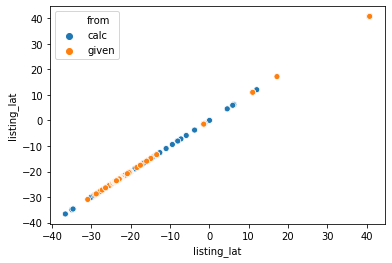

In [90]:
# doesn't look like our scoring func is agreeing with given data about new listing
sns.scatterplot(x = 'listing_lat', y = 'listing_lat', hue='from', data=new_listings)

Evaluate if model recommends new listings

In [114]:
source = new_listings[new_listings['from']=='calc']['cat_idx_listing'].values
dest = np.array([it for li in list(final_time_recs.values()) for it in li])
print(f'Percent of new listings (as per our calc) are recommended = \
{(np.intersect1d(source, dest).shape[0] / source.shape[0])*100}')

Percent of new listings (as per our calc) are recommended = 20.705890439205444


In [115]:
source = new_listings[new_listings['from']=='given']['cat_idx_listing'].values
dest = np.array([it for li in list(final_time_recs.values()) for it in li])
print(f'Percent of new listings (as per given) are recommended = \
{(np.intersect1d(source, dest).shape[0] / source.shape[0])*100}')

Percent of new listings (as per given) are recommended = 4.833178330620786


Next Steps:

1. Try param tuning & more data
2. Add a content model as fall back for cold start
3. Calculate propensity & diversity in recoms
4. Try LTR model - maybe catboost with contrastive loss from NDCG
5. Try Deep Learning model - maybe hierarchical attention 

Where can we use this model in Airbnb's marketplace?

I think that we can use this recommendation model to help more **users find listings of their economic preferance** by hueristically handling the post-processing step of generating recoms from a trained model. The same model choice can be applied to experiences as well.